# Structural Variant calling in Nanopore data


This notebook is intended for basic QC of long read sequencing files in fastq format, alignment of files in .bam format, and finally filtering and calling structural variants (SVs) into .VCF format. 

## Getting started

The first step is to download data from epi2me and install the packages we are going to need. 

In [131]:
from epi2melabs import ping
pinger = ping.Pingu()
pinger.send_notebook_ping('start', 'sv_tutorial')

# create a work directory and move into it
tutorial_name = "sv_tutorial"
working_dir = "/epi2melabs/{}/".format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

# Install additional packages via mamba
!mamba install lra cuteSV seqtk fastcat vcflib -yq

!mamba create -y -n my_environment
!. /opt/conda/etc/profile.d/conda.sh \
    && conda activate my_environment \
    &&  pip install Truvari \
    && pip install sniffles 

/epi2melabs/sv_tutorial

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.7.4) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: []

Preparing transaction: done
Verifying transaction: done
Executing transa

In [4]:
# Download sample data (click play)
import os

# download the data
location='s3://ont-exd-int-s3-euwst1-epi2me-labs/sv_tutorial'
s3_bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
s3_prefix = "sv_tutorial/GM24385.nf7.chr20_af_minimap2.fastq.gz"
s3_reference = "sv_tutorial/chr20_human_g1k_v37.fasta.gz"
s3_bedfile = "sv_tutorial/target.bed"
s3_alignments = "sv_tutorial/GM24385.nf7.chr20_af_minimap2.bam"
reads = os.path.basename(s3_prefix)
bam = os.path.basename(s3_alignments)
reference = os.path.basename(s3_reference)
!echo "Downloading sample data"
!wget -O "$reads" https://"$s3_bucket".s3.amazonaws.com/"$s3_prefix"
!wget -O "$reference" https://"$s3_bucket".s3.amazonaws.com/"$s3_reference"
!wget -O "target.bed" https://"$s3_bucket".s3.amazonaws.com/"$s3_bedfile"
!wget -O "$bam"  https://"$s3_bucket".s3.amazonaws.com/"$s3_alignments"

--2022-06-11 18:02:40--  https://ont-exd-int-s3-euwst1-epi2me-labs.s3.amazonaws.com/sv_tutorial/GM24385.nf7.chr20_af_minimap2.fastq.gz
Resolving ont-exd-int-s3-euwst1-epi2me-labs.s3.amazonaws.com (ont-exd-int-s3-euwst1-epi2me-labs.s3.amazonaws.com)... 52.218.25.66
Connecting to ont-exd-int-s3-euwst1-epi2me-labs.s3.amazonaws.com (ont-exd-int-s3-euwst1-epi2me-labs.s3.amazonaws.com)|52.218.25.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1869086183 (1.7G) [binary/octet-stream]
Saving to: ‘GM24385.nf7.chr20_af_minimap2.fastq.gz’

GM24385.nf7.chr20_a 100%[===================>]   1.74G  26.6MB/s    in 70s     

2022-06-11 18:03:51 (25.6 MB/s) - ‘GM24385.nf7.chr20_af_minimap2.fastq.gz’ saved [1869086183/1869086183]

--2022-06-11 18:03:51--  https://ont-exd-int-s3-euwst1-epi2me-labs.s3.amazonaws.com/sv_tutorial/chr20_human_g1k_v37.fasta.gz
Resolving ont-exd-int-s3-euwst1-epi2me-labs.s3.amazonaws.com (ont-exd-int-s3-euwst1-epi2me-labs.s3.amazonaws.com)... 52.218.2

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the appropriate file locations as input to the notebook.

The main inputs are:

fastq is the set of reads in .fastq format (gzip allowed).
reference is the reference genome file in .fasta format (gzip allowed).
target_bed is a .bed coordinate file that defines the genomic regions of interest. If you do not wish to filter by a region leave this field empty. See the appendix for more details.
threads defines the number of compute threads that will be used by the processes that can multi-thread. Please do not use more threads than are available on your computer.
Finally, we can also tune the characteristics of the SV analysis using the following inputs:

min_sv_length and max_sv_length defines the length of the shortest and longest allowable structural variations respectively.
min_read_length sets the minimum length of reads to be considered when discovering SVs.
min_read_support determines how many reads at minimum must be in support of a potential SV for it to be called.
mean_read_mapping_quality sets the minimum average quality of reads to be considered when discovering SVs.
The form below can also be edited to reflect different values for the above options, but sensible defaults are provided. Ensure that you click the form Enter button to set the variables for the rest of the workflow.

In [5]:
# Re-generate input form and global variables (click play)
import multiprocessing
import os

import aplanat
from aplanat import report, graphics
import ipywidgets as widgets
from epi2melabs.notebook import InputForm, InputSpec, cecho

# Inputs
fastq = None
reference = None
target_bed = None

# Parameters
threads = None
min_sv_length = None
max_sv_length = None
min_read_support = None
min_read_length = None
min_read_mapping_quality = None

# Intermediate results
aligned_bam = "aligned.bam"
calls_vcf = "calls.vcf"
filtered_vcf = "filtered.vcf"
sorted_filtered_vcf = "sorted.filtered.vcf"
sorted_filtered_vcf_gz = "sorted.filtered.vcf.gz"
depth_bedfile = 'depth.regions.bed.gz'
alignment_stats = "alignments.seqkit.tsv"

# Outputs
html_report = None
exec_summary = None


def process_form(inputs):
    global fastq, reference, target_bed, threads, \
        min_sv_length, max_sv_length, min_read_support, \
        min_read_length, min_read_mapping_quality, \
        html_report, exec_summary
    fastq = inputs.fastq
    reference = inputs.reference
    target_bed = inputs.target_bed
    threads = inputs.threads
    min_sv_length = inputs.min_sv_length
    max_sv_length = inputs.max_sv_length
    min_read_support = inputs.min_read_support
    min_read_length = inputs.min_read_length
    min_read_mapping_quality = inputs.min_read_mapping_quality
    
    if not os.path.isfile(fastq):
        !cecho error "Fastq '{}' does not exist.".format(fastq)
    if not os.path.isfile(reference):
        !cecho error "Reference '{}' does not exist.".format(reference)
    if target_bed != "" and not os.path.isfile:
        !cecho error "Target bed file '{}' does not exist.".format(target_bed)
    if min_sv_length < 0 or max_sv_length <= 0 or min_read_mapping_quality < 0:
        !echo error "Invalid value(s) given for `min_sv_length`, `max_read_length`, or `min_read_mapping_quality`."
        
    html_report = report.HTMLReport(
        "Structural Variation", "Summary of read alignments and SV discovery.",
        require_keys=True)
    html_report.markdown("## Executive Summary", "exec-title")
    html_report.placeholder("exec-plot")
    exec_summary = graphics.InfoGraphItems()

    !cecho success "Input validation complete"


input_form = InputForm(
    InputSpec('fastq', '.fastq reads file', 'GM24385.nf7.chr20_af_minimap2.fastq.gz'),
    InputSpec('reference', '.fasta reference file', 'chr20_human_g1k_v37.fasta.gz'),
    InputSpec('target_bed', '.bed target file', 'target.bed'),
    InputSpec('threads', 'Compute threads', (1, multiprocessing.cpu_count(), 1)),
    InputSpec('min_sv_length', 'Minimum SV length to report', widgets.IntText(30)),
    InputSpec('max_sv_length', 'Maximum SV length to report', widgets.IntText(1000000)),
    InputSpec('min_read_length', 'Minimum read length', widgets.IntText(1000)),
    InputSpec('min_read_support', 'Minimum reads to support variant', widgets.IntText(3)),
    InputSpec('min_read_mapping_quality', 'Minimum read mapping quality', widgets.IntText(20)),
    description_width="200px")
input_form.add_process_button(process_form)
input_form.display()

## Basic QC of Reads

We use Seqkit stats and fastcat to generate some statistics and then visualize these results 

In [192]:
#aligned_bam Run seqkit stats and fastcat to summarise read stats and plot results (click play)
import pandas as pd
from aplanat.components import fastcat

# Seqkit
read_stats = "reads.seqkit.tsv"

!seqkit stats -T -a -b -j {threads} {fastq} > {read_stats}


df_reads = pd.read_csv(read_stats, sep='\t',chunksize=int(1e6))
display(df_reads)

# Fastcat
per_read_stats = 'per_read_stats.txt'

!fastcat --read {per_read_stats} {fastq} > /dev/null


df_per_read = pd.read_csv(per_read_stats, sep='\t',chunksize=int(1e6))[['read_id','filename','read_length','mean_quality']]
display(df_per_read.head(10))

TypeError: 'TextFileReader' object is not subscriptable

## QC plots

(array([7.1515e+04, 9.4740e+03, 4.7670e+03, 2.0770e+03, 7.2900e+02,
        2.4500e+02, 6.6000e+01, 1.1000e+01, 8.0000e+00, 1.0000e+00]),
 array([1.520000e+02, 3.037740e+04, 6.060280e+04, 9.082820e+04,
        1.210536e+05, 1.512790e+05, 1.815044e+05, 2.117298e+05,
        2.419552e+05, 2.721806e+05, 3.024060e+05]),
 <BarContainer object of 10 artists>)

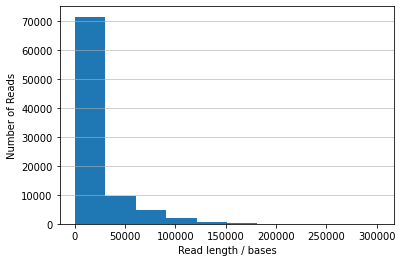

In [13]:
#plot the read length vs number of bases
import matplotlib.pyplot as plt
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Read length / bases')
plt.ylabel('Number of Reads')
plt.hist(x=df_per_read.read_length)

(array([6.9850e+03, 8.6820e+03, 1.0619e+04, 1.3105e+04, 1.6383e+04,
        1.7278e+04, 1.2234e+04, 3.3630e+03, 2.3600e+02, 8.0000e+00]),
 array([ 7.   ,  7.871,  8.742,  9.613, 10.484, 11.355, 12.226, 13.097,
        13.968, 14.839, 15.71 ]),
 <BarContainer object of 10 artists>)

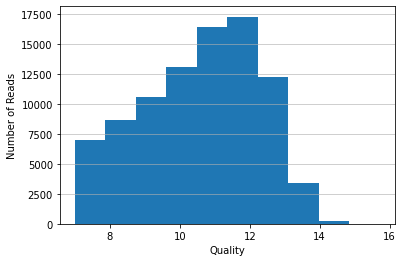

In [14]:
#measures the quality scores for the reads
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Quality')
plt.ylabel('Number of Reads')
plt.hist(x=df_per_read.mean_quality)

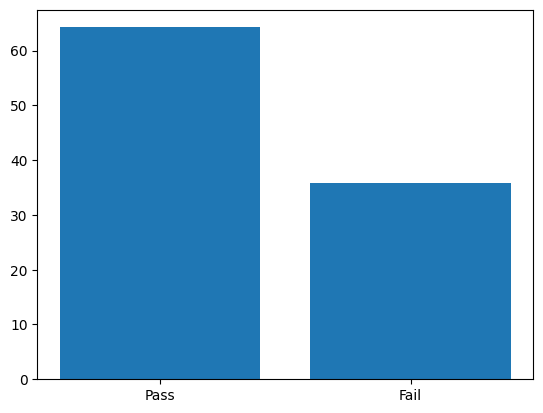

In [15]:
#this plot shows the pass / fail ratio with adjustable cutoff starting at 10
import matplotlib.pyplot as plt
import numpy as np

df_per_read['pass_fail']=np.where(df_per_read["mean_quality"] > 10,  True, False)
pass_percentage = 100 *sum(df_per_read["pass_fail"]) / len(df_per_read)
values = [pass_percentage, 100 - pass_percentage]
classes = ['Pass', 'Fail']

plt.rcdefaults()
fig, ax = plt.subplots()


ax.bar(classes, values)


plt.show()

## Alignment and processing of .bam file

In this step we run minimap2 to generate an aligned sam file. Further processing with samtools is then required.

In [16]:
!minimap2 -ax map-ont $reference $fastq > alignment.sam

[M::mm_idx_gen::3.039*0.89] collected minimizers
[M::mm_idx_gen::3.529*1.17] sorted minimizers
[M::main::3.530*1.17] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::3.745*1.16] mid_occ = 123
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::3.897*1.15] distinct minimizers: 8359911 (87.90% are singletons); average occurrences: 1.341; average spacing: 5.620
[M::worker_pipeline::179.870*2.84] mapped 26208 sequences
[M::worker_pipeline::372.497*3.02] mapped 26513 sequences
[M::worker_pipeline::472.814*3.05] mapped 27010 sequences
[M::worker_pipeline::503.062*3.01] mapped 9162 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -ax map-ont chr20_human_g1k_v37.fasta.gz GM24385.nf7.chr20_af_minimap2.fastq.gz
[M::main] Real time: 509.411 sec; CPU: 1520.660 sec; Peak RSS: 4.234 GB


In [18]:
!samtools sort -o sorted.alignment.bam alignment.sam
!samtools index sorted.alignment.bam
# run the alignment summarizer program
!stats_from_bam sorted.alignment.bam > sorted.alignment.bam.stats

[E::hts_open_format] Failed to open file "sorted.alignment.bam.tmp.0000.bam" : File exists
[E::hts_open_format] Failed to open file "sorted.alignment.bam.tmp.0001.bam" : File exists
[E::hts_open_format] Failed to open file "sorted.alignment.bam.tmp.0002.bam" : File exists
[bam_sort_core] merging from 3 files and 1 in-memory blocks...
Mapped/Unmapped/Short/Masked/Skipped(all matches masked): 88892/1/0/0/0


# Alignment QC

To QC the alignment we want to use the stats_from_bam command from the pomoxis library, which is included with epi2me.

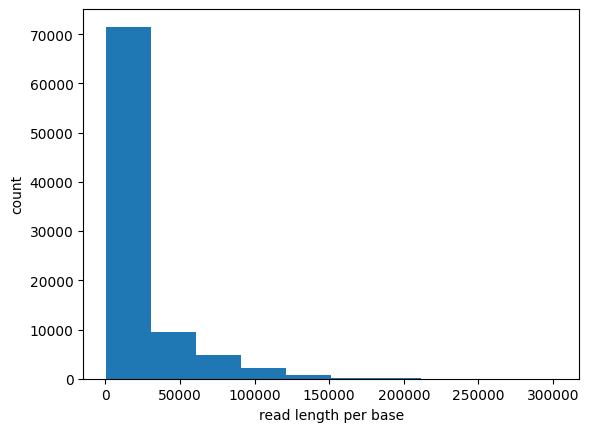

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("sorted.alignment.bam.stats", sep="\t")
plt.hist(df['read_length'])
plt.xlabel("read length per base")
plt.ylabel("count")
plt.show()

Text(0.5, 1.0, 'Read Accuracy')

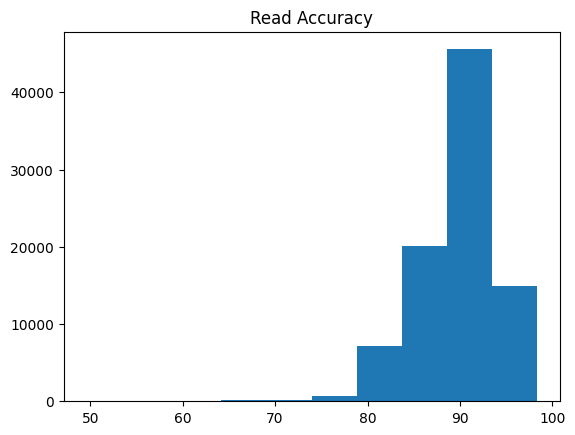

In [20]:
p2 = plt.hist(
    df['acc'])
plt.title("Read Accuracy")


## Find average depth with mosdepth

Calculating the depth stats is useful to determine cutoffs for variant calling

In [193]:
!mosdepth -n --fast-mode --by 500 sv_bams_depth sorted.alignment.bam
!ls ./sv_bams_depth*

depthstats = 'sv_bams_depth.mosdepth.summary.txt'
depth=pd.read_csv(depthstats, sep="\t")
avg_depth=depth[depth.chrom == "total"]["mean"]
avg_depth

./sv_bams_depth.mosdepth.global.dist.txt  ./sv_bams_depth.regions.bed.gz
./sv_bams_depth.mosdepth.region.dist.txt  ./sv_bams_depth.regions.bed.gz.csi
./sv_bams_depth.mosdepth.summary.txt


2    27.07
Name: mean, dtype: float64

# Variant Calling

CuteSV and Sniffles are Structural Variant callers that can analyze long reads. To compare them we will be benchmarking with Truvari

## CuteSV

In [22]:
unzipped = reference
if reference.endswith('.gz'):
    unzipped = reference.split('.gz')[0]
    unzipper = f"bgzip -d -c {reference} > {unzipped}"
    !$unzipper
    
!touch ./signatures
!rm -r ./signatures

!cuteSV --threads {threads} --genotype -l {min_sv_length} -L {max_sv_length -r {min_read_length} -q {min_read_mapping_quality} -s {min_read_support} \
                                                              --max_cluster_bias_INS 90 --diff_ratio_merging_INS 0.2 --max_cluster_bias_DEL 90 \
                                                              --dif_ratio_merging_DEL 0.3 sorted alignment.bam {unzipped} {calls.vcf} 


Running cuteSV --threads 6 --genotype -l 30 -L 1000000 -r 1000 -q 20 -s 3 --max_cluster_bias_INS 100 --diff_ratio_merging_INS 0.3 --max_cluster_bias_DEL 100 --diff_ratio_merging_DEL 0.3 sorted.alignment.bam chr20_human_g1k_v37.fasta calls.vcf .
2022-06-11 20:16:17,474 [INFO] Running /opt/conda/bin/cuteSV --threads 6 --genotype -l 30 -L 1000000 -r 1000 -q 20 -s 3 --max_cluster_bias_INS 100 --diff_ratio_merging_INS 0.3 --max_cluster_bias_DEL 100 --diff_ratio_merging_DEL 0.3 sorted.alignment.bam chr20_human_g1k_v37.fasta calls.vcf .
2022-06-11 20:16:17,494 [INFO] The total number of chromsomes: 1
2022-06-11 20:16:18,196 [INFO] Finished 20:50000000-60000000.
2022-06-11 20:16:18,255 [INFO] Finished 20:60000000-63025520.
2022-06-11 20:17:06,940 [INFO] Finished 20:20000000-30000000.
2022-06-11 20:17:22,083 [INFO] Finished 20:0-10000000.
2022-06-11 20:17:22,494 [INFO] Finished 20:10000000-20000000.
2022-06-11 20:17:23,427 [INFO] Finished 20:40000000-50000000.
2022-06-11 20:17:25,497 [INFO] Fin

Filtering with vcflib to reduce size of analysis 

In [24]:
!vcffilter -f "SVTYPE = DEL | SVTYPE = INS & SVLEN > 30 & SVLEN < 100000 & RE > 5" calls.vcf > cute.filtered.vcf

## Sniffles

In [25]:
!sniffles --input sorted.alignment.bam --snf sample1.snf
!sniffles --input sample1.snf --vcf sniffles.calls.vcf

Running Sniffles2, build 2.0.6
  Run Mode: call_sample
  Start on: 2022/06/11 20:19:17
  Working dir: /epi2melabs/sv_tutorial
  Used command: /opt/conda/bin/sniffles --input sorted.alignment.bam --snf sample1.snf
Opening for reading: sorted.alignment.bam
Opening for writing: sample1.snf
Sniffles2 Error: Output file 'sample1.snf' already exists! Use --allow-overwrite to ignore this check and overwrite. (Fatal error, exiting.)
Running Sniffles2, build 2.0.6
  Run Mode: combine
  Start on: 2022/06/11 20:19:18
  Working dir: /epi2melabs/sv_tutorial
  Used command: /opt/conda/bin/sniffles --input sample1.snf --vcf sniffles.calls.vcf
Sniffles2 Error: Output file 'sniffles.calls.vcf' already exists! Use --allow-overwrite to ignore this check and overwrite. (Fatal error, exiting.)


Using equivalent filter on Sniffles output vcf in order to better compare the two callers.

In [26]:
!vcffilter -f "SVTYPE = DEL | SVTYPE = INS & SVLEN > 30 & SVLEN < 100000 & COVERAGE > 5" sniffles.calls.vcf > sniffles.filtered.vcf

## SV density karyograms

These should result in karyograms with densities only on chr20, where we restricted our analysis.

In [85]:

import aplanat
from aplanat import bio
import pandas as pd
import numpy as np
from bokeh.layouts import gridplot

def parse_vcf(fname):
    header = "CHROM POS ID REF ALT QUAL FILTER INFO FORMAT GT".split()
    vcf = pd.read_csv(fname, delimiter='\t', comment='#', names=header, dtype={'CHROM':str})
    #print(vcf.head())
    # The INFO field isn't quite a table, so this is cumbersome
    info = vcf['INFO'].str.split(pat=";",expand=True, n=1)
    info.replace(";IMPRECISE",";TYPE=IMPRECISE",inplace=True,regex=True)
    info.replace(";PRECISE",";TYPE=PRECISE",inplace=True,regex=True)
    vcf['STATUS'] = info[0]
    vcf['details'] = info[1].str.split(";").apply(lambda x: dict([y.split("=") for y in x]))
    for field in ['SVTYPE', 'SVLEN']:
        vcf[field] = vcf['details'].apply(lambda x: x[field])
    # filter to chromosome
    allowed = [str(x) for x in range(1,23)] + ['X','Y']
    vcf = vcf.loc[vcf['CHROM'].isin(allowed)]
    for orig, rename in (('INS', 'Insertion'), ('DEL', 'Deletion')):
        vcf.loc[vcf['SVTYPE'] == orig, 'SVTYPE'] = rename
    vcf['SVLEN'] = vcf['SVLEN'].astype(int)
    return vcf

sniffles_vcf="sniffles.filtered.vcf"
cute_vcf="cute.filtered.vcf"
vcf_cute = parse_vcf(cute_vcf)
vcf_sniffles=parse_vcf(sniffles_vcf)
vcf_cute["aligner"]="cuteSV"
vcf_sniffles["aligner"]="Sniffles"
sv_types = ('Insertion', 'Deletion')
aligners= ('Sniffles', 'cuteSV')

vcf=pd.concat([vcf_cute,vcf_sniffles])

svs = ('Insertion', 'Deletion')
sv_cols = ['maroon', 'darkgreen']
karyograms_sniffles = list()
karyograms_cute = list()
for sv, col in zip(svs, sv_cols):
    data = vcf_sniffles.loc[vcf_sniffles['SVTYPE'] == sv]
    plot = bio.karyotype(
        [data['POS']], [data['CHROM']], [sv], [col], alpha=0.2,
        height=300, width=400)
    karyograms_sniffles.append(plot)
    data = vcf_cute.loc[vcf_cute['SVTYPE'] == sv]
    plot = bio.karyotype(
        [data['POS']], [data['CHROM']], [sv], [col], alpha=0.2,
        height=300, width=400)
    karyograms_cute.append(plot)
karyograms = gridplot([karyograms_cute, karyograms_sniffles])

aplanat.show(karyograms)

## SV length barplots

We might want to characterize the differences between insert/deletion sizes by using barplots.

In [129]:
from aplanat import hist, annot
import matplotlib.pyplot as plt
aligner_cols=["blue","red"]
plots=list()
for aligner, alncol in zip(aligners, aligner_cols):
    data = vcf.loc[vcf['aligner'] == aligner]
    for sv,col in zip(svs,sv_cols):
        data2 = data.loc[data['SVTYPE'] == sv]["SVLEN"].abs()
        plot=hist.histogram([data2],colors=[col],
                           title="{1}: {0} SV lengths".format(sv,aligner))
        plots.append(plot)
plots=gridplot(plots,ncols=4)
aplanat.show(plots)

# Benchmarking with Truvari

First we need to download our benchmark from GIAB and filter it down to chr20. We also want to index and bgzip our result vcf files. 

In [195]:
!wget https://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/AshkenazimTrio/analysis/NIST_SVs_Integration_v0.6/HG002_SVs_Tier1_v0.6.vcf.gz
!bgzip -f sniffles.filtered.vcf
!lra index -ONT {reference} 
!bgzip sniffles.filtered.vcf
!tabix -p vcf sniffles.filtered.vcf.gz
!bgzip cute.filtered.vcf
!tabix -p vcf cute.filtered.vcf.gz
!tabix -p vcf HG002_SVs_Tier1_v0.6.vcf.gz 
!vcftools --gzvcf HG002_SVs_Tier1_v0.6.vcf.gz --chr 20 --recode --out chr20_HG002_SVs_Tier1_v0.6
!bgzip -f chr20_HG002_SVs_Tier1_v0.6.recode.vcf
!tabix -p vcf chr20_HG002_SVs_Tier1_v0.6.recode.vcf.gz 
!truvari bench -b chr20_HG002_SVs_Tier1_v0.6.recode.vcf.gz  -c sniffles.filtered.vcf.gz -f chr20_human_g1k_v37.fasta.gz  -o "sniffles_truvari"
!truvari bench -b chr20_HG002_SVs_Tier1_v0.6.recode.vcf.gz  -c cute.filtered.vcf.gz -f chr20_human_g1k_v37.fasta.gz -o "cute_truvari"

--2022-06-12 14:29:17--  https://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/AshkenazimTrio/analysis/NIST_SVs_Integration_v0.6/HG002_SVs_Tier1_v0.6.vcf.gz
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.10, 130.14.250.7, 2607:f220:41e:250::12, ...
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25738211 (25M) [application/x-gzip]
Saving to: ‘HG002_SVs_Tier1_v0.6.vcf.gz.1’

HG002_SVs_Tier1_v0. 100%[===================>]  24.54M  21.0MB/s    in 1.2s    

2022-06-12 14:29:18 (21.0 MB/s) - ‘HG002_SVs_Tier1_v0.6.vcf.gz.1’ saved [25738211/25738211]

[bgzip] No such file or directory: sniffles.filtered.vcf
Sorting 12577827 minimizers
done Sorting
11939234 minimizers with multiplicity smaller than 150
There are 3849252 minimizers left
[bgzip] No such file or directory: sniffles.filtered.vcf
[tabix] the index file exists. Please use '-f' to over

In [196]:
perf_cute=pd.read_json("cute_truvari/summary.txt")
perf_sniffles=pd.read_json("sniffles_truvari/summary.txt")

In [197]:
perf_cute.head(1)

,TP-base,TP-call,FP,FN,precision,recall,f1,base cnt,call cnt,TP-call_TP-gt,TP-call_FP-gt,TP-base_TP-gt,TP-base_FP-gt,gt_concordance,gt_matrix
"(0, 0)",275,275,189,531,0.592672,0.341191,0.433071,806,464,232,43,232,43,0.843636,"{'(0, 0)': 3}"


In [198]:
perf_sniffles.head(1)

,TP-base,TP-call,FP,FN,precision,recall,f1,base cnt,call cnt,TP-call_TP-gt,TP-call_FP-gt,TP-base_TP-gt,TP-base_FP-gt,gt_concordance,gt_matrix
"(0, 1)",201,201,156,605,0.563025,0.24938,0.345658,806,357,164,37,164,37,0.81592,"{'(0, 1)': 81, '(1, 1)': 4}"
